In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing Atlantic Hurricane data

In [105]:
df = pd.read_csv('/Users/danielbrechner/hurrdat_co2/assets/atlantic.csv')
df.head()

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,AL011851,UNNAMED,18510625,0,,HU,28.0N,94.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,UNNAMED,18510625,600,,HU,28.0N,95.4W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,UNNAMED,18510625,1200,,HU,28.0N,96.0W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,UNNAMED,18510625,1800,,HU,28.1N,96.5W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,UNNAMED,18510625,2100,L,HU,28.2N,96.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


In [106]:
df.shape

(49105, 22)

The naming convention was applied to hurricanes starting in 1950. This might indicate better data quality, so we will use hurricane data from 1950 to the most recent year in the dataset

In [107]:
#boolean indexing to df
hurricanes = df[df['Date'] >= 19500000]
hurricanes.head()

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
21879,AL011950,ABLE,19500812,0,,TS,17.1N,55.5W,35,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
21880,AL011950,ABLE,19500812,600,,TS,17.7N,56.3W,40,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
21881,AL011950,ABLE,19500812,1200,,TS,18.2N,57.4W,45,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
21882,AL011950,ABLE,19500812,1800,,TS,19.0N,58.6W,50,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
21883,AL011950,ABLE,19500813,0,,TS,20.0N,60.0W,50,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


In [108]:
hurricanes.shape

(27226, 22)

Dropping unnecessary columns

In [109]:
hurricanes = hurricanes.drop(columns=['ID', 'Time', 'Event', 'Low Wind NE', 'Low Wind SE', 'Low Wind SW', 'Low Wind NW', 'Moderate Wind NE', 'Moderate Wind SE', 'Moderate Wind SW', 'Moderate Wind NW', 'High Wind NE', 'High Wind SE', 'High Wind SW', 'High Wind NW'], axis = 1,)


In [110]:
hurricanes.head()

,Name,Date,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure
21879,ABLE,19500812,TS,17.1N,55.5W,35,-999
21880,ABLE,19500812,TS,17.7N,56.3W,40,-999
21881,ABLE,19500812,TS,18.2N,57.4W,45,-999
21882,ABLE,19500812,TS,19.0N,58.6W,50,-999
21883,ABLE,19500813,TS,20.0N,60.0W,50,-999


In [111]:
hurricanes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27226 entries, 21879 to 49104
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Name              27226 non-null  object
 1   Date              27226 non-null  int64 
 2   Status            27226 non-null  object
 3   Latitude          27226 non-null  object
 4   Longitude         27226 non-null  object
 5   Maximum Wind      27226 non-null  int64 
 6   Minimum Pressure  27226 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 1.7+ MB


Converting to datetime 

In [112]:
hurricanes['Date'] = pd.to_datetime(hurricanes['Date'].astype(str), format = '%Y %m %d')
hurricanes

,Name,Date,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure
21879,ABLE,1950-08-12,TS,17.1N,55.5W,35,-999
21880,ABLE,1950-08-12,TS,17.7N,56.3W,40,-999
21881,ABLE,1950-08-12,TS,18.2N,57.4W,45,-999
21882,ABLE,1950-08-12,TS,19.0N,58.6W,50,-999
21883,ABLE,1950-08-13,TS,20.0N,60.0W,50,-999
...,...,...,...,...,...,...,...
49100,KATE,2015-11-12,EX,41.3N,50.4W,55,981
49101,KATE,2015-11-12,EX,41.9N,49.9W,55,983
49102,KATE,2015-11-13,EX,41.5N,49.2W,50,985
49103,KATE,2015-11-13,EX,40.8N,47.5W,45,985


Adding seperate year and month columns

In [113]:
hurricanes['Year'] = hurricanes['Date'].map(lambda x: x.year)
hurricanes['Month'] = hurricanes['Date'].map(lambda x: x.month)
hurricanes.head()

,Name,Date,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,Year,Month
21879,ABLE,1950-08-12,TS,17.1N,55.5W,35,-999,1950,8
21880,ABLE,1950-08-12,TS,17.7N,56.3W,40,-999,1950,8
21881,ABLE,1950-08-12,TS,18.2N,57.4W,45,-999,1950,8
21882,ABLE,1950-08-12,TS,19.0N,58.6W,50,-999,1950,8
21883,ABLE,1950-08-13,TS,20.0N,60.0W,50,-999,1950,8


In [114]:
print(hurricanes['Year'].unique())

[1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015]


In [115]:
print(hurricanes['Month'].unique())

[ 8  9 10 11  1  5 12  2  6  7  4]


According to this dataset, no values for March exist

In [116]:
hurricanes.dtypes

Name                        object
Date                datetime64[ns]
Status                      object
Latitude                    object
Longitude                   object
Maximum Wind                 int64
Minimum Pressure             int64
Year                         int64
Month                        int64
dtype: object

No null values are found but negative values such as -999 for wind represents null. Lets drop these values from the dataset and convert to NaN.

In [117]:
cols_to_check = ['Maximum Wind', 'Minimum Pressure']
negative_mask = (hurricanes[cols_to_check] < 0)
hurricanes[cols_to_check] = hurricanes[cols_to_check].mask(negative_mask, np.nan)


In [118]:
negative_exist = ((hurricanes['Maximum Wind'] < 0) | (hurricanes['Minimum Pressure'] < 0)).any()
print("The number of negative values in the Maximum Wind and Minimum Pressure columns are:", negative_exist.sum())

The number of negative values in the Maximum Wind and Minimum Pressure columns are: 0


Dropping hemisphere tags from coordinates

In [119]:
hurricanes['Latitude'] = hurricanes['Latitude'].str[:-1].astype(float)
hurricanes['Longitude'] = hurricanes['Longitude'].str[:-1].astype(float)

In [120]:
print(hurricanes[['Latitude', 'Longitude']].head())

       Latitude  Longitude
21879      17.1       55.5
21880      17.7       56.3
21881      18.2       57.4
21882      19.0       58.6
21883      20.0       60.0


# Grouping storms by Max Wind Speed

In [122]:
max_wind_speeds = hurricanes.loc[hurricanes.groupby('Name')['Maximum Wind'].idxmax(), ['Name', 'Maximum Wind', 'Year', 'Month']]
max_wind_speeds


,Name,Maximum Wind,Year,Month
31610,AMY,60.0,1975,6
35322,ANA,60.0,1985,7
37712,BOB,100.0,1991,8
22074,DOG,125.0,1950,9
46971,DON,45.0,2011,7
...,...,...,...,...
28964,FRANCELIA,100.0,1969,9
36987,GABRIELLE,125.0,1989,9
35158,JOSEPHINE,90.0,1984,10
39369,SEBASTIEN,55.0,1995,10


# Data Visualization

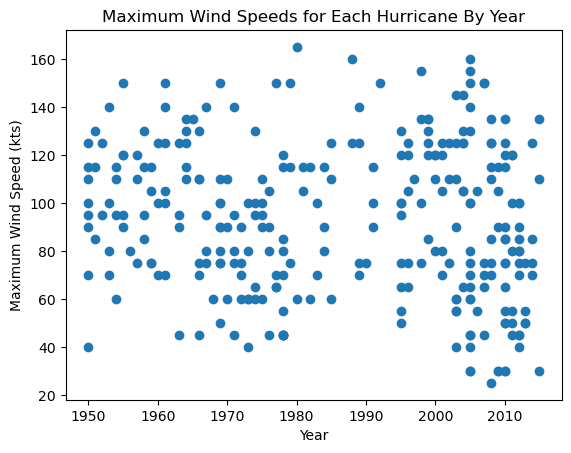

In [135]:
plt.plot(max_wind_speeds['Year'], max_wind_speeds['Maximum Wind'], 'o')
plt.xlabel('Year')
plt.ylabel('Maximum Wind Speed (kts)')
plt.title('Maximum Wind Speeds for Each Hurricane By Year')
plt.show()

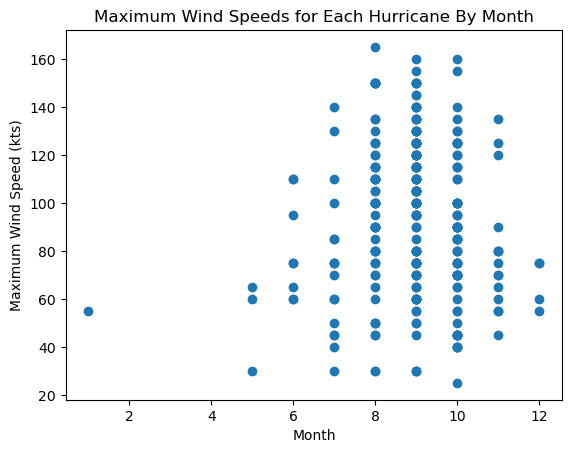

In [136]:
plt.plot(max_wind_speeds['Month'], max_wind_speeds['Maximum Wind'], 'o')
plt.xlabel('Month')
plt.ylabel('Maximum Wind Speed (kts)')
plt.title('Maximum Wind Speeds for Each Hurricane By Month')
plt.show()

We can see the distribution of storms throughout the year. With the majority of storms happening between July and November

# Looking at the distribution of Storms per year

In [221]:
storms_per_year = max_wind_speeds.groupby('Year').size().reset_index(name='Number of storms')
storms_per_year

,Year,Number of storms
0,1950,8
1,1951,3
2,1952,2
3,1953,4
4,1954,4
...,...,...
56,2011,7
57,2012,11
58,2013,4
59,2014,4


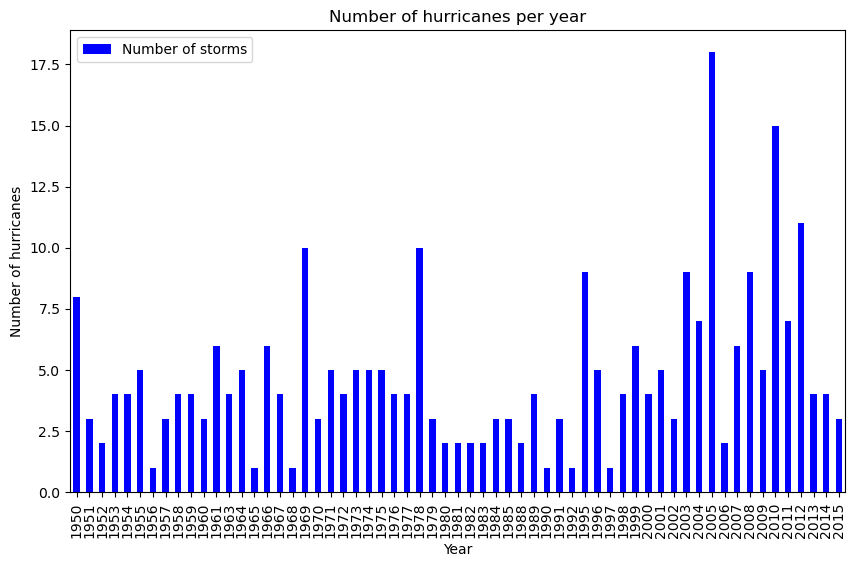

In [222]:
ax = storms_per_year.plot(kind='bar', x='Year', y='Number of storms', color='blue',figsize=(10, 6))

ax.set_title('Number of hurricanes per year')
ax.set_xlabel('Year')
ax.set_ylabel('Number of hurricanes')

plt.show()